In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math,logging
import os,sys
parentdir = os.path.dirname(os.path.abspath('.'))
temp_path = os.path.join(parentdir,'JY_Toolkit')
sys.path.insert(0,temp_path)
# from JY_Toolkit import Jy_makeDataset,Jy_dataSetProcess
import JY_Toolkit
from JY_Toolkit import Jy_dataShow

random_seed = 5225

logging.basicConfig(level=logging.INFO)
logging.info(f'logging info normal , success')

INFO:root:logging info normal , success


## 构筑双月数据集用以实验

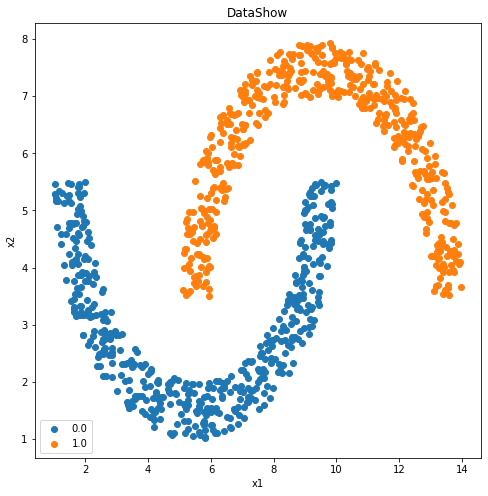

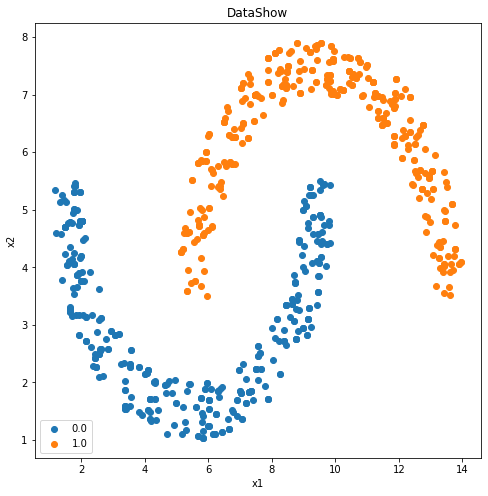

(array([9.30306338, 4.87471821]), 0.0)

In [2]:
X,y = JY_Toolkit.Jy_makeDataset.draw_HalfMoon(n_sample=1000,slope= 0,ver_distance=-2,positive_val=1,negative_val=0)
Jy_dataShow.show_TwoDimData(X,y)
X_train,X_test,y_train,y_test = JY_Toolkit.Jy_dataSetProcess.Jy_train_test_split(X,y)
Jy_dataShow.show_TwoDimData(X_train,y_train)

X_train[0],y_train[0]

In [3]:
class MLP(object):
    def __init__(self,
                 structure: tuple,
                 *,
                 activate='sigmoid'):
        self.layers = structure
        self.num_layers = len(structure)
        self.structure = structure
        self.weights = [np.random.randn(n, m+1)
                        for n, m in zip(structure[1:], structure[:-1])]
        self.loss_rate = []
        print(f'self.weights : {self.weights}  END')
        if activate == 'sigmoid':
            self.ac = MLP.sigmoid
            self.ac_Derivative_1 = MLP.sigmoid_Derivative_1
        if activate == 'relu':
            self.ac = MLP.Relu
            self.ac_Derivative_1 = MLP.Relu_Derivative_1

        pass
    # 激活函数

    def sigmoid(z):
        ans = 1.0/(1.0 + np.exp(-z))
        return ans

    def sigmoid_Derivative_1(z):
        # sigmoid 函数的一阶导数
        return MLP.sigmoid(z) * (1 - MLP.sigmoid(z))

    def Relu(z):
        return max(0, z)

    def Relu_Derivative_1(z):
        if z >= 0:
            return 1
        else:
            return 0
    # 前向传播

    def single_feed_forwaed(self, x):
        # 对单个样本的前向传播
        temp_value = x
        # 对每一层的遍历
        for i in range(len(self.weights)):
            # 打印 增广前的输出
            # logging.info(f' temp_value : {temp_value} , shape : {temp_value.size}')
            # temp_value.append(1.0)
            temp_value = np.r_[temp_value, 1]
            # 打印 增广后的输出
            # logging.info(f'after append, temp_value : {temp_value}')
            temp_value = self.ac(
                np.dot(self.weights[i], temp_value))
            # logging.info(f'res : {temp_value}')
        y = temp_value
        return y

    def backprop(self, x, y):
        # x,y 输入单个样本数据和其期望输出
        delta_w = [np.zeros(w.shape) for w in self.weights]
        v = []  # 诱导局部域
        # temp = np.r_[x, 1]
        temp = x
        z = [temp]  # 激活函数输出，节点的输出,以及输入层的输入
        # 前向传播，存储下各层的诱导局部域以及各节点的输出
        for w in self.weights:
            temp = np.r_[temp, 1]
            # 计算诱导局部域
            temp = np.dot(w, temp)
            v.append(temp)
            # 经过激活函数，计算节点输出
            temp = self.ac(temp)
            z.append(temp)

        # print('v :', v, '\n', 'z', z)

        # 计算输出层的局部梯度 \delta
        e = z[-1] - y
        local_delta = e * self.ac_Derivative_1(v[-1])
        # logging.info(f'local_delta:{local_delta} ,type:{type(local_delta)} , z[-2]: {z[-2]}')
        # z[-1] 是网络的最终输出，我们需要取输出层的输入，所以应该取z[-2], 因为要考虑到偏执项，故增广1列
        # delta_w[-1] = local_delta * np.r_[z[-2], 1]
        delta_w[-1] = np.dot(local_delta , np.r_[z[-2], 1].reshape(self.weights[-1].shape))
        # print(f'delta_w[-1] : {delta_w[-1]} , size :{delta_w[-1].shape}')
        # 计算每一层的 Delta
        for i in range(2, self.num_layers):
            # print(local_delta,'@',self.weights[-i+1][:, :-1],'ans = ', np.dot(local_delta,self.weights[-i+1][:, :-1]))
            local_delta = self.ac_Derivative_1(
                v[-i]) * np.dot(local_delta, self.weights[-i+1][:, :-1])
            # logging.info(f'local_delta:{local_delta.shape} , z[-i-1]:{z[-i-1].shape}')
            # print(
            #     f'local_delta : {local_delta} , np.r_[z[-i-1],1] : {np.r_[z[-i-1],1]}')
            delta_w[-i] = np.dot(local_delta.reshape(len(local_delta),1), np.r_[z[-i-1], 1].reshape(1,len(np.r_[z[-i-1], 1])))
            # print(f'delta_w[-i] : {delta_w[-i]}')
        return delta_w

    def update_mini_batch(self, batch_X, batch_y, learning_rate, batch_size):
        # 定义一个总的 Delta w 和，将batch内每个样本的 delta累加起来
        all_delta_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in zip(batch_X, batch_y):
            delta_w = self.backprop(x, y)
            # print(f'delta_w : {delta_w}')
            all_delta_w = [a+b for a, b in zip(all_delta_w, delta_w)]
        # print(f'all_delta_w = {all_delta_w}')
        self.weights = [w - (learning_rate/batch_size) *
                        Delta for w, Delta in zip(self.weights, all_delta_w)]

    def MBGD(self, X_train, y_train,
             *,
             epochs=10,
             batch_size=1,
             learning_rate=0.001):
        self.loss_rate.clear()
        for _iter in range(epochs):
            X = [X_train[k:k+batch_size]
                 for k in range(0, len(X_train), batch_size)]
            y = [y_train[k:k+batch_size]
                 for k in range(0, len(y_train), batch_size)]
            for batch_X, batch_y in zip(X, y):
                self.update_mini_batch(
                    batch_X, batch_y, learning_rate, batch_size)
            accuracy = self.score(X_train, y_train)
            self.loss_rate.append(1 - 100*accuracy/len(X_train))
            print(
                f"Epoch : {epochs} , _iter:{_iter} , accuracy : {accuracy},accracy_rate = {100*accuracy/len(X_train)}%")

    def predict_single(self, x):
        res = self.single_feed_forwaed(x)
        if res >= 0.5:
            return 1
        else:
            return 0

    def score(self, X, y):
        accuracy_count = 0
        for features, expect_label in zip(X, y):
            predict_label = self.predict_single(features)
            if predict_label == expect_label:
                accuracy_count += 1
        return accuracy_count
    pass


# test
layer = [[2,20,1],[2, 100,100, 1],[2,100,200,100,1]]
mistake_line = []
mlp = MLP((2, 100,100, 1))
for i in range(len(layer)):
    mlp = MLP(layer[i])
    mlp.MBGD(X_train, y_train,batch_size= 1,epochs=1000,learning_rate=0.0005)
    mlp.score(X_test, y_test)/len(X_test)
    mistake_line.append(mlp.loss_rate)



self.weights : [array([[-1.5346732 ,  1.24784257, -0.85304692],
       [ 0.24653117,  0.16870604,  1.45849079],
       [ 0.39384055,  0.10280799, -0.23320546],
       [ 0.83172864,  0.36145126, -0.44782262],
       [-0.47962852, -2.06820753, -0.32048854],
       [-0.47676046,  0.17185519,  0.82992195],
       [ 0.12552014,  1.450013  , -0.992709  ],
       [-0.07270032, -0.78814975, -0.44717266],
       [ 1.08841913,  0.30813702,  0.46268184],
       [-0.68938027, -0.14227675, -1.30836019],
       [ 0.76341876,  0.71690186, -0.33044089],
       [-0.04350722,  0.25210698, -1.85229   ],
       [ 0.35263835,  0.21085873,  0.28296597],
       [-0.2226138 ,  1.57920448,  1.08950489],
       [ 0.45094402,  0.95831507, -0.04128735],
       [-0.14340064,  0.86755697, -0.73278217],
       [-0.62509925, -0.52269599, -0.20036477],
       [ 0.00314361,  0.54217045, -0.08507467],
       [ 1.12795337, -0.32738374, -0.73300917],
       [ 1.36421712,  1.97749458,  0.28302969],
       [-0.1640647 ,  0.

<class 'numpy.ndarray'> (800, 2)


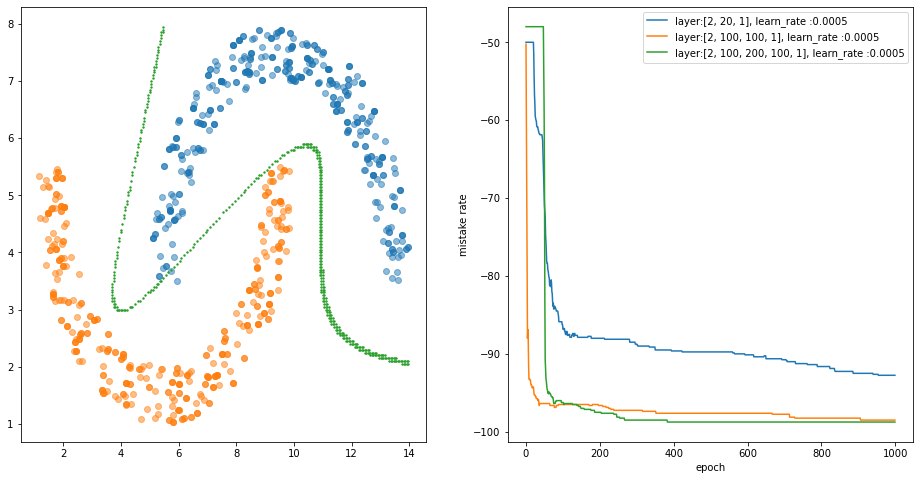

In [4]:
line_p_x = []
line_p_y = []

print(type(X_train) , X_train.shape)

p_point_x1 = [ X_train[i,0] for i in range(len(X_train)) if y_train[i] == 1]
p_point_x2 = [ X_train[i,1] for i in range(len(X_train)) if y_train[i] == 1]
n_point_x1 = [ X_train[i,0] for i in range(len(X_train)) if y_train[i] == 0]
n_point_x2 = [ X_train[i,1] for i in range(len(X_train)) if y_train[i] == 0]

for x in np.arange( 0.0, 14., 0.05):  # 取点x=-15~25  y=-10~10 带入前向计算 得出y_p
    for y in np.arange(0., 8., 0.05):
        res = mlp.single_feed_forwaed((x, y))
        if (res-0.5)**2 <=0.0005:
            line_p_x.append(x)
            line_p_y.append(y)

fig = plt.figure(num=1,figsize = (16,8))
ax_1 = fig.add_subplot(121)
ax_2 = fig.add_subplot(122)
ax_1.scatter(p_point_x1, p_point_x2, alpha=0.5)
ax_1.scatter(n_point_x1, n_point_x2, alpha=0.5)
ax_1.scatter(line_p_x, line_p_y,s = 2)

ax_2.set_xlabel('epoch')
ax_2.set_ylabel('mistake rate')

for i in range(len(layer)):
    ax_2.plot(range(len(mistake_line[i])),mistake_line[i],label=f'layer:{layer[i]}, learn_rate :0.0005')
ax_2.legend(loc = 1)

plt.show()